Epoch 1/20, Loss: 0.3292
Epoch 2/20, Loss: 0.0396
Epoch 3/20, Loss: 0.0046
Epoch 4/20, Loss: 0.0013
Epoch 5/20, Loss: 0.0008
Epoch 6/20, Loss: 0.0006
Epoch 7/20, Loss: 0.0005
Epoch 8/20, Loss: 0.0004
Epoch 9/20, Loss: 0.0003
Epoch 10/20, Loss: 0.0003
Epoch 11/20, Loss: 0.0002
Epoch 12/20, Loss: 0.0002
Epoch 13/20, Loss: 0.0002
Epoch 14/20, Loss: 0.0002
Epoch 15/20, Loss: 0.0002
Epoch 16/20, Loss: 0.0001
Epoch 17/20, Loss: 0.0001
Epoch 18/20, Loss: 0.0001
Epoch 19/20, Loss: 0.0001
Epoch 20/20, Loss: 0.0001
Test Loss: 0.0001
Epoch 1/20, Loss: 0.4368
Epoch 2/20, Loss: 0.1200
Epoch 3/20, Loss: 0.0438
Epoch 4/20, Loss: 0.0177
Epoch 5/20, Loss: 0.0044
Epoch 6/20, Loss: 0.0010
Epoch 7/20, Loss: 0.0006
Epoch 8/20, Loss: 0.0006
Epoch 9/20, Loss: 0.0006
Epoch 10/20, Loss: 0.0006
Epoch 11/20, Loss: 0.0006
Epoch 12/20, Loss: 0.0006
Epoch 13/20, Loss: 0.0006
Epoch 14/20, Loss: 0.0006
Epoch 15/20, Loss: 0.0006
Epoch 16/20, Loss: 0.0006
Epoch 17/20, Loss: 0.0006
Epoch 18/20, Loss: 0.0006
Epoch 19/20,

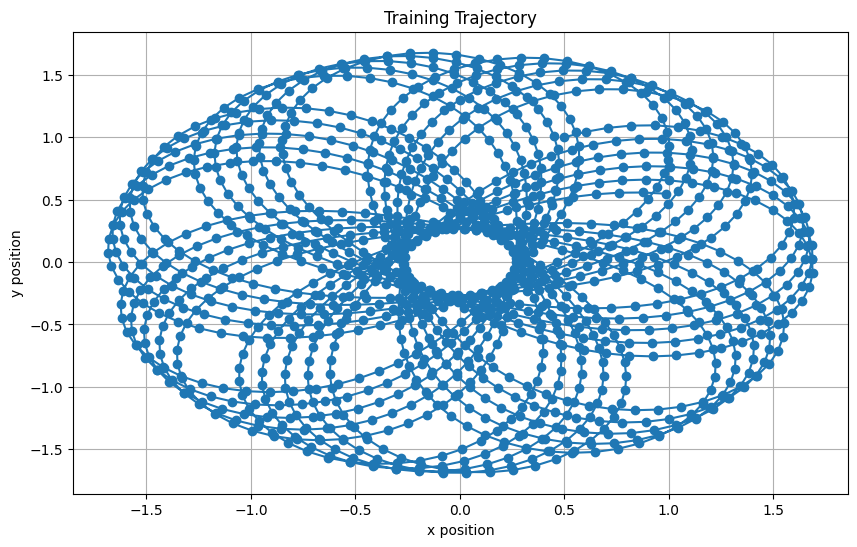

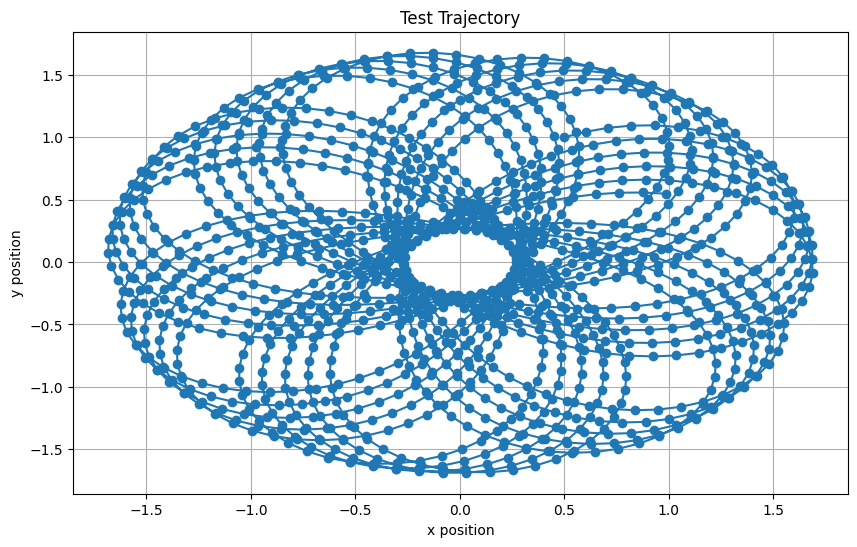

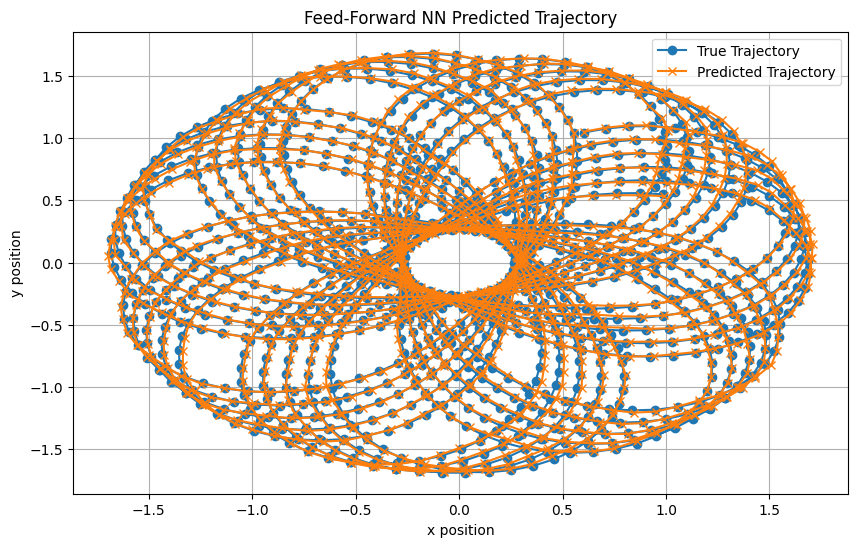

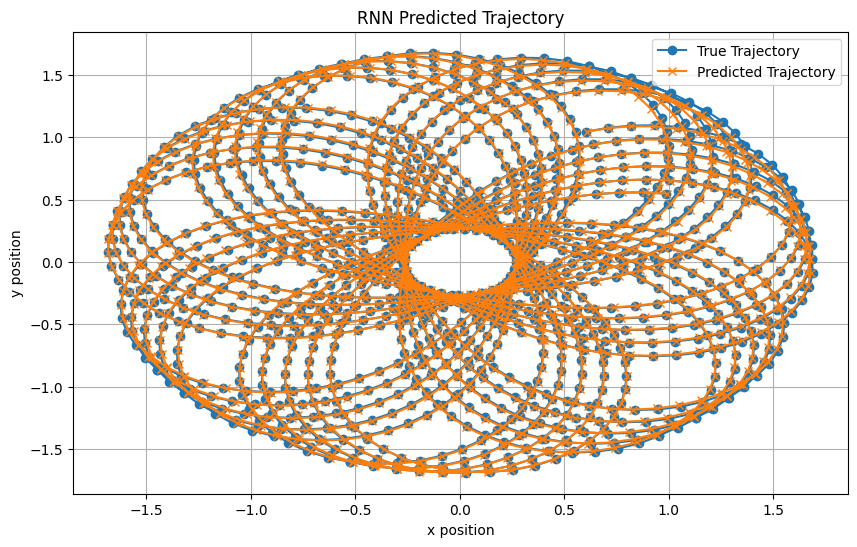

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Load data from text file
def load_data(file_path):
    data = np.loadtxt(file_path)
    velocities = data[:, :2]
    positions = data[:, 2:]
    return velocities, positions

train_velocities, train_positions = load_data('data_lorentz/train.txt')
test_velocities, test_positions = load_data('data_lorentz/test.txt')

# Create input-output pairs for training
def create_pairs(velocities, positions):
    input_states = np.hstack((velocities[:-1], positions[:-1]))
    output_states = np.hstack((velocities[1:], positions[1:]))
    return input_states, output_states

train_input_states, train_output_states = create_pairs(train_velocities, train_positions)
test_input_states, test_output_states = create_pairs(test_velocities, test_positions)

# Convert data to PyTorch tensors
train_input_states = torch.tensor(train_input_states, dtype=torch.float32)
train_output_states = torch.tensor(train_output_states, dtype=torch.float32)
test_input_states = torch.tensor(test_input_states, dtype=torch.float32)
test_output_states = torch.tensor(test_output_states, dtype=torch.float32)

# Create dataset and dataloader
train_dataset = torch.utils.data.TensorDataset(train_input_states, train_output_states)
test_dataset = torch.utils.data.TensorDataset(test_input_states, test_output_states)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the FeedForwardNN
class FeedForwardNN(nn.Module):
    def __init__(self):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 4)
        
    def forward(self, input_states):
        x = torch.relu(self.fc1(input_states))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model, define loss function and optimizer
model = FeedForwardNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
def train_model(model, train_loader, criterion, optimizer, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for input_states, output_states in train_loader:
            optimizer.zero_grad()
            outputs = model(input_states)
            loss = criterion(outputs, output_states)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * input_states.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

train_model(model, train_loader, criterion, optimizer)

# Evaluate the model
def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for input_states, output_states in test_loader:
            outputs = model(input_states)
            loss = criterion(outputs, output_states)
            total_loss += loss.item() * input_states.size(0)
    
    avg_loss = total_loss / len(test_loader.dataset)
    print(f'Test Loss: {avg_loss:.4f}')

evaluate_model(model, test_loader, criterion)

# Define the RecurrentNN
class RecurrentNN(nn.Module):
    def __init__(self, input_size=4, hidden_size=64, output_size=4, num_layers=1):
        super(RecurrentNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, input_states):
        x = input_states.unsqueeze(1)  # Add sequence dimension
        h_0 = torch.zeros(1, x.size(0), 64)  # Initial hidden state
        out, _ = self.rnn(x, h_0)
        out = self.fc(out[:, -1, :])
        return out

# Instantiate the RNN model, define loss function and optimizer
rnn_model = RecurrentNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

# Train the RNN model
train_model(rnn_model, train_loader, criterion, optimizer)
# Evaluate the RNN model
evaluate_model(rnn_model, test_loader, criterion)

# Visualization functions
def plot_positions(positions, title):
    x = positions[:, 0]
    y = positions[:, 1]
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker='o')
    plt.title(title)
    plt.xlabel('x position')
    plt.ylabel('y position')
    plt.grid(True)
    plt.show()

# Convert positions from tensor to numpy for plotting
# train_positions_np = train_positions.numpy()
# test_positions_np = test_positions.numpy()

# Plot training positions
plot_positions(train_positions, 'Training Trajectory')

# Plot test positions
plot_positions(test_positions, 'Test Trajectory')

def plot_predicted_trajectories(model, input_states, true_positions, title):
    model.eval()
    with torch.no_grad():
        predicted_states = model(input_states).numpy()
    
    predicted_positions = predicted_states[:, 2:]  # Extract predicted positions
    
    plt.figure(figsize=(10, 6))
    plt.plot(true_positions[:, 0], true_positions[:, 1], label='True Trajectory', marker='o')
    plt.plot(predicted_positions[:, 0], predicted_positions[:, 1], label='Predicted Trajectory', marker='x')
    plt.title(title)
    plt.xlabel('x position')
    plt.ylabel('y position')
    plt.legend()
    plt.grid(True)
    plt.show()

# Prepare input data for plotting predicted trajectories
test_input_states_np = test_input_states.numpy()
test_output_positions_np = test_output_states[:, 2:].numpy()

# Plot predicted trajectories for feed-forward neural network
plot_predicted_trajectories(model, test_input_states, test_output_positions_np, 'Feed-Forward NN Predicted Trajectory')

# Plot predicted trajectories for recurrent neural network
plot_predicted_trajectories(rnn_model, test_input_states, test_output_positions_np, 'RNN Predicted Trajectory')
